In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.manifold import TSNE
import math
import matplotlib.pyplot as plt

In [2]:
def get_reference_data(reference_path):
    data = pd.read_excel(reference_path)# read data from the given path
    reference_data = pd.DataFrame(np.delete(np.matrix(data),data.shape[1]-1,axis=1))
    label = data[data.shape[1]-1] 
    return reference_data,label

In [3]:
def get_query_data(query_path):
    data = pd.read_excel(query_path)# read data from the given path
    return query

In [4]:
def preprocess(reference_data,query):
    #log transfrom
    reference_data = np.log(1+reference_data)
    query = np.log(1+query)
    return reference_data,query

In [5]:
def p(x):
    return math.sqrt(2/math.pi)*(x*(math.exp(-.5/x/x)-1)+math.erf(1/x))

def rho(c,x):
    return math.log(p(x))/math.log(p(c*x))

def grid_search(c,grid):
    t1 = grid[0]
    t2 = grid[1]
    n = int(math.log(0.01/(t2-t1))/math.log(0.618))
    for i in range(n):
        m1 = t2+0.618*(t1-t2)
        m2 = t1+0.618*(t2-t1)
        if rho(c,m1)>rho(c,m2):
            t1  = m1
        else:
            t2 = m2
    return 0.5*(t1+t2)

def calculate_sigma(c):
    grid = np.array([0,0.2])
    sigma = 1
    for i in range(5):
        sigma_i = grid_search(c,grid)
        if rho(c,sigma)>rho(c,sigma_i):
            sigma = sigma_i
        grid = grid+0.2
    return sigma


In [6]:

def selecting_paraments(r,c,reference_shape):
    DATA_SIZE = reference_shape[1]
    NUM_CELL = reference_shape[0]

    r_w = calculate_sigma(c)
    W = r/r_w
    
    # calculate p1 and p2
    p1 = p(r_w)
    p2 = p(c*r_w)
    # Parameters
    NUM_HYPERLANE = int(-math.log(NUM_CELL)/math.log(p2))+1 # the number of hyperlane used per hash fuction(k)
    NUM_TABLE = int(math.pow(NUM_CELL,rho(c,r_w)))+1 # num of hash table l
    return DATA_SIZE,NUM_CELL,NUM_HYPERLANE,NUM_TABLE,p1,p2,W

In [7]:
#random projection
def random_matrix(DATA_SIZE,NUM_CELL,NUM_HYPERLANE,NUM_TABLE):
    matrix = np.random.random(DATA_SIZE*NUM_HYPERLANE*NUM_TABLE)-0.5
    matrix.resize([NUM_TABLE,NUM_HYPERLANE,DATA_SIZE])
    for i in range(NUM_TABLE):
        for j in range(NUM_HYPERLANE):
            matrix[i][j]=matrix[i][j]/np.linalg.norm(matrix[i][j])
    return matrix

def random_B(NUM_HYPERLANE,NUM_TABLE,W):
    B = np.random.random(NUM_HYPERLANE*NUM_TABLE)*W
    B.resize(NUM_TABLE,NUM_HYPERLANE)
    return B

def random_projection(reference_data,query,DATA_SIZE,NUM_CELL,NUM_HYPERLANE,NUM_TABLE,W):
    matrix = random_matrix(DATA_SIZE,NUM_CELL,NUM_HYPERLANE,NUM_TABLE)
    B = random_B(NUM_HYPERLANE,NUM_TABLE,W)
    B_multi = np.tile(B,NUM_CELL).reshape([NUM_TABLE,NUM_CELL,NUM_HYPERLANE]).transpose(0,2,1)
    #get reference hash table
    hashvalue_reference = np.trunc((np.dot(matrix,np.transpose(reference_data))+B_multi)/W).transpose(0,2,1)
    #get query hash value
    hashvalue_query = np.trunc((np.dot(matrix,np.transpose(query))+B)/W)
    
    return hashvalue_reference,hashvalue_query

In [8]:
def search_hash_table(hashvalue_reference,hashvalue_query,top_hits_num,NUM_CELL,NUM_TABLE):
    hit_num = np.zeros(NUM_CELL)
    for i in range(NUM_TABLE):
            deta = hashvalue_query[i]-hashvalue_reference[i]
            hit_num = hit_num+np.trunc(sum(deta.transpose())==0)#记录全匹配上的数量
    top_hits_index  =np.argsort(hit_num)[0:top_hits_num]
    return top_hits_index

In [9]:
def visualization(reference_data,query,top_hits_index):
    tsne=TSNE()
    tsne_reslut = tsne.fit_transform(np.vstack((reference_data,query)))
    tsne_top_hits = pd.DataFrame(tsne_reslut[top_hits_index])
    tsne_query = tsne_reslut[tsne_reslut.shape[1]-1]
    tsne_reslut = pd.DataFrame(tsne_reslut)
    plt.plot(tsne_reslut[0],tsne_reslut[1],'ko')
    plt.plot(tsne_top_hits[0],tsne_top_hits[1],'ro')
    plt.plot(tsne_query[0],tsne_query[1],'go')
    plt.show()

In [10]:
reference_data,label=get_reference_data('simu_data_5000*21_2.xlsx')

In [15]:
query = reference_data.loc[1,:]
c = 10

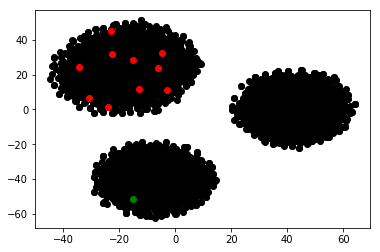

In [16]:
#reference_data,query = preprocess(reference_data,query)
# select paraments
DATA_SIZE,NUM_CELL,NUM_HYPERLANE,NUM_TABLE,p1,p2,W = selecting_paraments(1,c,reference_data.shape)
top_hits_num = 10 # top hits number
# random projection
hashvalue_reference,hashvalue_query = random_projection(reference_data,query,DATA_SIZE,NUM_CELL,NUM_HYPERLANE,NUM_TABLE,W)
# find top hits
top_hits_index=search_hash_table(hashvalue_reference,hashvalue_query,top_hits_num,NUM_CELL,NUM_TABLE)
# visualization
visualization(reference_data,query,top_hits_index)